In [1]:
import os

print("CWD:", os.getcwd())
print("Root files:", os.listdir("."))

print("data folder exists?:", os.path.exists("data"))
if os.path.exists("data"):
    print("data files:", os.listdir("data"))

CWD: c:\Users\acer\Desktop\Mental_Health_NLP_Project\notebook
Root files: ['check_data.py', 'preprocessing_and_baseline.ipynb']
data folder exists?: False


In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("../data/mental_health_large.csv")

print("Shape:", df.shape)
print("Columns:", list(df.columns))
df.head()

Shape: (53043, 3)
Columns: ['Unnamed: 0', 'statement', 'status']


,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [4]:
# 1) Unnecessary column remove
df = df.drop(columns=["Unnamed: 0"])

# 2) Rename label column
df = df.rename(columns={"status": "label"})

# 3) Drop missing values
df = df.dropna(subset=["statement", "label"])

print("Shape after cleaning:", df.shape)
print("\nNull counts:\n", df.isnull().sum())
df.head()

Shape after cleaning: (52681, 2)

Null counts:
 statement    0
label        0
dtype: int64


,statement,label
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [5]:
label_counts = df["label"].value_counts()
print(label_counts)

print("\nNumber of classes:", df["label"].nunique())
print("\nClass names:", sorted(df["label"].unique()))

label
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

Number of classes: 7

Class names: ['Anxiety', 'Bipolar', 'Depression', 'Normal', 'Personality disorder', 'Stress', 'Suicidal']


In [6]:
X = df["statement"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

print("\nTrain label distribution (top):")
print(y_train.value_counts().head(10))

print("\nTest label distribution (top):")
print(y_test.value_counts().head(10))

Train size: (42144,)
Test size: (10537,)

Train label distribution (top):
label
Normal                  13074
Depression              12323
Suicidal                 8521
Anxiety                  3073
Bipolar                  2221
Stress                   2070
Personality disorder      862
Name: count, dtype: int64

Test label distribution (top):
label
Normal                  3269
Depression              3081
Suicidal                2131
Anxiety                  768
Bipolar                  556
Stress                   517
Personality disorder     215
Name: count, dtype: int64


In [7]:
tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("X_train_tfidf shape:", X_train_tfidf.shape)
print("X_test_tfidf shape:", X_test_tfidf.shape)

X_train_tfidf shape: (42144, 20000)
X_test_tfidf shape: (10537, 20000)


In [8]:
lr = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
    class_weight="balanced"
)

lr.fit(X_train_tfidf, y_train)

print("Model trained!")
print("Classes:", lr.classes_)

c:\Users\acer\Desktop\Mental_Health_NLP_Project\venv311\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


Model trained!
Classes: ['Anxiety' 'Bipolar' 'Depression' 'Normal' 'Personality disorder' 'Stress'
 'Suicidal']


In [9]:
y_pred = lr.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.7636898547973806

Classification Report:

                      precision    recall  f1-score   support

             Anxiety       0.77      0.80      0.79       768
             Bipolar       0.75      0.81      0.78       556
          Depression       0.79      0.62      0.70      3081
              Normal       0.88      0.91      0.89      3269
Personality disorder       0.56      0.71      0.63       215
              Stress       0.52      0.68      0.59       517
            Suicidal       0.67      0.75      0.70      2131

            accuracy                           0.76     10537
           macro avg       0.71      0.75      0.73     10537
        weighted avg       0.77      0.76      0.76     10537



<Figure size 900x900 with 0 Axes>

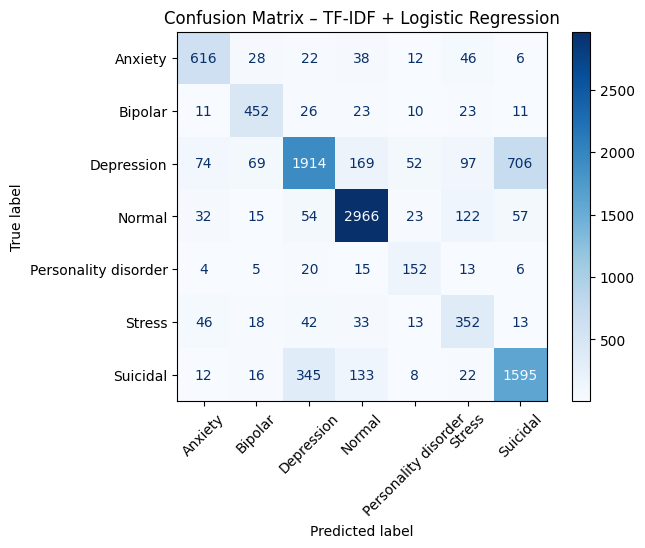

In [10]:
cm = confusion_matrix(y_test, y_pred, labels=lr.classes_)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=lr.classes_
)

plt.figure(figsize=(9, 9))
disp.plot(cmap="Blues", xticks_rotation=45, values_format="d")
plt.title("Confusion Matrix – TF-IDF + Logistic Regression")
plt.show()

In [11]:
def predict_mental_health(text: str) -> str:
    text_vector = tfidf.transform([text])
    prediction = lr.predict(text_vector)[0]
    return prediction

In [12]:
user_text = input("Enter your text: ")
result = predict_mental_health(user_text)

print("\nPredicted Mental Health Category:", result)


Predicted Mental Health Category: Suicidal


In [13]:
import joblib
import os

# save folder (project root এ models নামে folder বানাবে)
os.makedirs("../models", exist_ok=True)

joblib.dump(tfidf, "../models/tfidf.joblib")
joblib.dump(lr, "../models/mental_health_lr.joblib")

print("Saved:")
print(" - ../models/tfidf.joblib")
print(" - ../models/mental_health_lr.joblib")

Saved:
 - ../models/tfidf.joblib
 - ../models/mental_health_lr.joblib


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

lr2 = LogisticRegression(
    max_iter=3000,
    solver="saga",
    n_jobs=-1,
    class_weight="balanced",
    C=3.0
)

lr2.fit(X_train_tfidf, y_train)
y_pred2 = lr2.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

c:\Users\acer\Desktop\Mental_Health_NLP_Project\venv311\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


Accuracy: 0.7520167030464079
                      precision    recall  f1-score   support

             Anxiety       0.81      0.78      0.79       768
             Bipolar       0.73      0.83      0.78       556
          Depression       0.79      0.58      0.67      3081
              Normal       0.89      0.91      0.90      3269
Personality disorder       0.59      0.67      0.63       215
              Stress       0.44      0.72      0.55       517
            Suicidal       0.64      0.75      0.69      2131

            accuracy                           0.75     10537
           macro avg       0.70      0.75      0.72     10537
        weighted avg       0.77      0.75      0.75     10537



c:\Users\acer\Desktop\Mental_Health_NLP_Project\venv311\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [15]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

svm = LinearSVC(class_weight="balanced")
svm.fit(X_train_tfidf, y_train)

y_pred_svm = svm.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

Accuracy: 0.7602733225775837
                      precision    recall  f1-score   support

             Anxiety       0.78      0.81      0.80       768
             Bipolar       0.76      0.81      0.78       556
          Depression       0.74      0.66      0.69      3081
              Normal       0.87      0.93      0.90      3269
Personality disorder       0.70      0.67      0.68       215
              Stress       0.58      0.57      0.58       517
            Suicidal       0.65      0.68      0.67      2131

            accuracy                           0.76     10537
           macro avg       0.73      0.73      0.73     10537
        weighted avg       0.76      0.76      0.76     10537



In [16]:
import joblib
import os

os.makedirs("../models", exist_ok=True)

joblib.dump(tfidf, "../models/tfidf.joblib")           # same vectorizer
joblib.dump(svm, "../models/mental_health_svm.joblib") # new model

print("Saved:")
print(" - ../models/tfidf.joblib")
print(" - ../models/mental_health_svm.joblib")

Saved:
 - ../models/tfidf.joblib
 - ../models/mental_health_svm.joblib


In [17]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, classification_report

# Base SVM (fast + strong)
svm_base = LinearSVC(class_weight="balanced")
svm_base.fit(X_train_tfidf, y_train)

# Calibration to get probabilities (slower, but gives percentage)
svm_calibrated = CalibratedClassifierCV(
    estimator=svm_base,
    method="sigmoid",
    cv=3
)

svm_calibrated.fit(X_train_tfidf, y_train)

y_pred_cal = svm_calibrated.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred_cal))
print(classification_report(y_test, y_pred_cal))

Accuracy: 0.7677707127265825
                      precision    recall  f1-score   support

             Anxiety       0.85      0.76      0.80       768
             Bipolar       0.87      0.76      0.81       556
          Depression       0.69      0.73      0.71      3081
              Normal       0.86      0.94      0.90      3269
Personality disorder       0.87      0.58      0.69       215
              Stress       0.77      0.43      0.55       517
            Suicidal       0.67      0.66      0.67      2131

            accuracy                           0.77     10537
           macro avg       0.80      0.69      0.73     10537
        weighted avg       0.77      0.77      0.76     10537



In [18]:
import joblib
import os

os.makedirs("../models", exist_ok=True)

joblib.dump(tfidf, "../models/tfidf.joblib")
joblib.dump(svm_calibrated, "../models/mental_health_svm_calibrated.joblib")

print("Saved:")
print(" - ../models/tfidf.joblib")
print(" - ../models/mental_health_svm_calibrated.joblib")

Saved:
 - ../models/tfidf.joblib
 - ../models/mental_health_svm_calibrated.joblib


In [19]:
print(type(X_train), type(y_train))
print("Train size:", len(X_train), "Test size:", len(X_test))
print("Example text:", str(X_train.iloc[0])[:150] if hasattr(X_train, "iloc") else str(X_train[0])[:150])

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
Train size: 42144 Test size: 10537
Example text: I have not tried them. I do not like the idea of needing pills to be happy my whole life. Why do not some of you guys try antidepressants?


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    analyzer="char_wb",
    ngram_range=(3,5),
    min_df=2,
    sublinear_tf=True
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF shapes:", X_train_tfidf.shape, X_test_tfidf.shape)

c:\Users\acer\Desktop\Mental_Health_NLP_Project\venv311\Lib\site-packages\sklearn\feature_extraction\text.py:548: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


TF-IDF shapes: (42144, 182440) (10537, 182440)


In [21]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, classification_report

# 1) Base SVM
svm_base = LinearSVC(class_weight="balanced")
svm_base.fit(X_train_tfidf, y_train)

# 2) Calibrate for probabilities (cv=3)
svm_calibrated = CalibratedClassifierCV(
    estimator=svm_base,
    method="sigmoid",
    cv=3
)

svm_calibrated.fit(X_train_tfidf, y_train)

# 3) Evaluate
y_pred = svm_calibrated.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7998481541235646
                      precision    recall  f1-score   support

             Anxiety       0.86      0.82      0.84       768
             Bipolar       0.88      0.79      0.83       556
          Depression       0.74      0.76      0.75      3081
              Normal       0.90      0.95      0.92      3269
Personality disorder       0.82      0.67      0.74       215
              Stress       0.69      0.58      0.63       517
            Suicidal       0.70      0.69      0.70      2131

            accuracy                           0.80     10537
           macro avg       0.80      0.75      0.77     10537
        weighted avg       0.80      0.80      0.80     10537



In [22]:
import os
import joblib

# notebook folder থেকে models folder এ save করার জন্য
os.makedirs("../models", exist_ok=True)

joblib.dump(tfidf, "../models/tfidf.joblib")
joblib.dump(svm_calibrated, "../models/mental_health_svm_calibrated.joblib")

print("Saved OK:")
print(" - ../models/tfidf.joblib")
print(" - ../models/mental_health_svm_calibrated.joblib")

Saved OK:
 - ../models/tfidf.joblib
 - ../models/mental_health_svm_calibrated.joblib


In [1]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

# 1) predict on test
y_pred = svm_calibrated.predict(X_test_tfidf)

# 2) report (optional, but keep)
print(classification_report(y_test, y_pred))

# 3) confusion matrix
labels = list(svm_calibrated.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)

cm_df = pd.DataFrame(
    cm,
    index=[f"true_{l}" for l in labels],
    columns=[f"pred_{l}" for l in labels]
)

cm_df

NameError: name 'svm_calibrated' is not defined

In [ ]:
import joblib

tfidf = joblib.load("../models/tfidf.joblib")
svm_calibrated = joblib.load("../models/mental_health_svm_calibrated.joblib")

print("Loaded OK:", type(tfidf), type(svm_calibrated))
print("Classes:", svm_calibrated.classes_)